In [ ]:
import pandas as pd 





def map_categorical_values(dataset, column, unique_values, standard_format):
    categoryMapping = dict(zip(unique_values, standard_format))
    dataset[column] = dataset[column].map(categoryMapping)
    return dataset


# df = pd.read_csv('all_issues.csv')
# # df

uniqueVals = ["Female", "M", "Male", "Woman", "F"]
standardFormat = ['F', 'M', 'M', 'F', 'F']

mappedData = map_categorical_values('all_issues.csv', 'Gender', uniqueVals, standardFormat)
print(mappedData)


Old Data with Ouliers: 10
Without Ouliers: 6


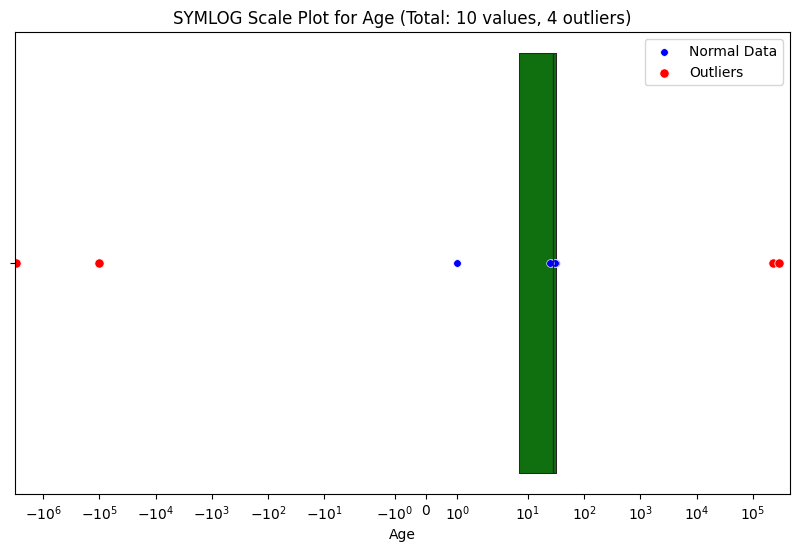

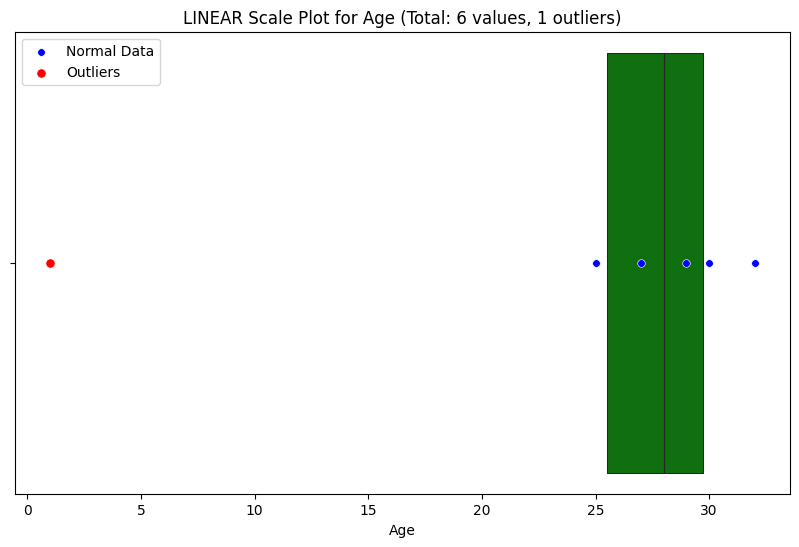

,Name,Age,Gender,Description,Date
1,Bob,29,M,Software engineer,NaN
2,NaN,1,Male,Avid reader,2023-02-15
3,Diana,32,Woman,NaN,2023/03/10
5,Fiona,27,Female,NaN,2023-04-25
6,NaN,30,M,NaN,NaN
7,Hannah,25,Female,Book lover,2023-05-30


In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# np.random.seed(0)
# normal_sales = np.random.uniform(100, 500, 95)
# outliers = np.array([1000, 1200, 1500, -200, -300, 000000, 300000000000])
# sales_data = np.concatenate([normal_sales, outliers])
# df = pd.DataFrame({'Sales': sales_data})
df = pd.read_csv('all_issues.csv')


def calculate_iqr_thresholds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    outlier_threshold_lower = q1 - 1.5 * iqr
    outlier_threshold_upper = q3 + 1.5 * iqr
    return outlier_threshold_lower, outlier_threshold_upper

def choose_xscale(df, column):
    # Count the number of data points
    num_points = df[column].count()
    data_range = df[column].max() - df[column].min()
    
    # Check if the data contains negative or zero values
    has_negatives = (df[column] < 0).any()
    has_zeros = (df[column] == 0).any()

    # Decide on the scale based on dataset size and properties
    if has_negatives:
        # Use 'symlog' if there are negative values
        return 'symlog'
    elif has_zeros:
        # Avoid 'log' if there are zeros
        return 'symlog' if num_points > 500 else 'linear'
    else:
        # Use 'log' if the data spans several orders of magnitude and no zeros/negatives
        if data_range > 1000 and num_points > 100:
            return 'log'
        # For small data ranges or small dataset sizes, use 'linear'
        return 'linear' if num_points < 100 else 'log'
    
def plot_boxen_with_outliers(df, column):
    # Calculate IQR thresholds
    outlier_threshold_lower, outlier_threshold_upper = calculate_iqr_thresholds(df[column])

    normal_data = df[(df[column] >= outlier_threshold_lower) & (df[column] <= outlier_threshold_upper)]
    outliers = df[(df[column] < outlier_threshold_lower) | (df[column] > outlier_threshold_upper)]

    num_points = len(df)
    point_size = 10 if num_points > 500 else 30  # Smaller points for larger datasets
    fig_width = 10 if num_points > 500 else 5    # Larger figure for larger datasets

    # Plot boxen plot
    plt.figure(figsize=(10, 6))
    sns.boxenplot(data=df, x=column, color="green", showfliers=False)

    # Overlay normal data points in blue and outliers in red
    sns.scatterplot(data=normal_data, x=column, y=[0] * len(normal_data), color='blue', s=point_size, label='Normal Data')
    sns.scatterplot(data=outliers, x=column, y=[0] * len(outliers), color='red', s=point_size * 1.5, label='Outliers')

    #Plot Scale
    scale = choose_xscale(df, column)
    plt.xscale(scale)

    # Set title with number of elements, and add a legend
    plt.title(f'{scale.upper()} Scale Plot for {column} (Total: {num_points} values, {len(outliers)} outliers)')
    plt.legend()

    # Show the plot
    plt.show()

def filter_outliers_by_z_score(df, column):
    lower_limit, upper_limit = calculate_iqr_thresholds(df[column])
    new_df = df.loc[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return new_df



column = 'Age'
new_df = filter_outliers_by_z_score(df, column)

print(f"Old Data with Ouliers: {len(df)}")
print(f"Without Ouliers: {len(new_df)}")

plot_boxen_with_outliers(df, column)
plot_boxen_with_outliers(new_df, column)

# df
new_df

Data is skewed. Using IQR for outlier detection.


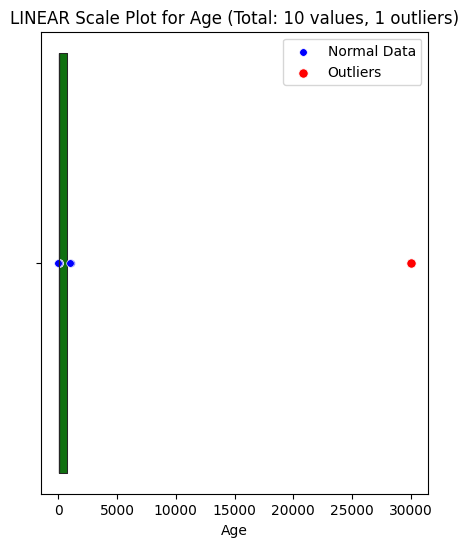

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Read your dataset
# np.random.seed(0)
# normal_sales = np.random.uniform(100, 500, 95)
# outliers = np.array([1000, 1200, 1500, -200, -300, 90000000, 300000000000])
# sales_data = np.concatenate([normal_sales, outliers])
# df = pd.DataFrame({'Sales': sales_data})

df = pd.read_csv('all_issues.csv')

# Function to calculate IQR thresholds
def calculate_iqr_thresholds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    outlier_threshold_lower = q1 - 1.5 * iqr
    outlier_threshold_upper = q3 + 1.5 * iqr
    return outlier_threshold_lower, outlier_threshold_upper

# Function to choose x-scale based on the dataset
def choose_xscale(df, column):
    num_points = df[column].count()
    data_range = df[column].max() - df[column].min()
    has_negatives = (df[column] < 0).any()
    has_zeros = (df[column] == 0).any()

    if has_negatives:
        return 'symlog'
    elif has_zeros:
        return 'symlog' if num_points > 500 else 'linear'
    else:
        if data_range > 1000 and num_points > 100:
            return 'log'
        return 'linear' if num_points < 100 else 'log'

# Function to plot boxen plot with outliers
def plot_boxen_with_outliers(df, column, method):
    # Choose the method dynamically
    if method == 'Z-score':
        z_scores = zscore(df[column])
        outliers = df[np.abs(z_scores) > 3]
    elif method == 'IQR':
        lower_limit, upper_limit = calculate_iqr_thresholds(df[column])
        outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
    elif method == 'Isolation Forest':
        model = IsolationForest()
        outlier_preds = model.fit_predict(df[[column]])
        outliers = df[outlier_preds == -1]
    elif method == 'LOF':
        model = LocalOutlierFactor()
        outlier_preds = model.fit_predict(df[[column]])
        outliers = df[outlier_preds == -1]

    # Plot the results
    normal_data = df[~df.index.isin(outliers.index)]
    num_points = len(df)
    point_size = 10 if num_points > 500 else 30
    fig_width = 10 if num_points > 500 else 5

    plt.figure(figsize=(fig_width, 6))
    sns.boxenplot(data=df, x=column, color="green", showfliers=False)
    sns.scatterplot(data=normal_data, x=column, y=[0] * len(normal_data), color='blue', s=point_size, label='Normal Data')
    sns.scatterplot(data=outliers, x=column, y=[0] * len(outliers), color='red', s=point_size * 1.5, label='Outliers')

    scale = choose_xscale(df, column)
    plt.xscale(scale)

    plt.title(f'{scale.upper()} Scale Plot for {column} (Total: {num_points} values, {len(outliers)} outliers)')
    plt.legend()
    plt.show()

def choose_outlier_detection_method(df, column):
    skewness = df[column].skew()
    is_normal = abs(skewness) < 0.5
    is_high_dimensional = len(np.unique(column)) > 10
    is_clustered = len(np.unique(df[column])) > 10

    if is_normal:
        print("Data is normally distributed. Using Z-score for outlier detection.")
        return 'Z-score'
    elif not is_normal and not is_high_dimensional:
        print("Data is skewed. Using IQR for outlier detection.")
        return 'IQR'
    elif is_high_dimensional:
        print("Data is high-dimensional. Using Isolation Forest for outlier detection.")
        return 'Isolation Forest'
    elif is_clustered:
        print("Data has clusters. Using Local Outlier Factor (LOF) for outlier detection.")
        return 'LOF'
    else:
        print("Using default method: IQR.")
        return 'IQR'

# Main code execution to process the dataset and plot results
column = 'Age'

# Choose the best method for outlier detection
method = choose_outlier_detection_method(df, column)

# Apply the selected method and plot the results
plot_boxen_with_outliers(df, column, method)


<Axes: ylabel='Sales'>

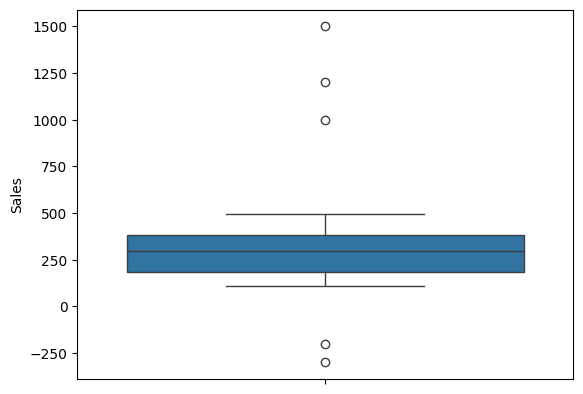

In [22]:
import numpy as np
import seaborn as sns

np.random.seed(0)

# Generate 95 values between 100 and 500
normal_sales = np.random.uniform(100, 500, 95)

# Generate 5 outlier values (e.g., much higher and much lower than the normal range)
outliers = np.array([1000, 1200, 1500, -200, -300])

# Combine normal data and outliers
sales_data = np.concatenate([normal_sales, outliers])

# Create a DataFrame
df = pd.DataFrame({'Sales': sales_data})
sns.boxplot(df['Sales'])


In [ ]:
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from flask import Flask, send_file, request, jsonify

app = Flask(__name__)

def plot_boxen_with_outliers(df, column):
    # Calculate IQR and outlier thresholds
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    outlier_threshold_lower = q1 - 1.5 * iqr
    outlier_threshold_upper = q3 + 1.5 * iqr

    # Separate normal data and outliers
    normal_data = df[(df[column] >= outlier_threshold_lower) & (df[column] <= outlier_threshold_upper)]
    outliers = df[(df[column] < outlier_threshold_lower) | (df[column] > outlier_threshold_upper)]

    # Calculate the size and spacing based on the number of data points
    num_points = len(df)
    point_size = 10 if num_points > 500 else 30  # Smaller points for larger datasets
    fig_width = 10 if num_points > 500 else 5     # Larger figure for larger datasets

    # Plot boxen plot
    plt.figure(figsize=(fig_width, 6))
    sns.boxenplot(data=df, x=column, color="green", showfliers=False)

    # Overlay normal data points in blue and outliers in red
    sns.scatterplot(data=normal_data, x=column, y=[0] * len(normal_data), color='blue', s=point_size, label='Normal Data')
    sns.scatterplot(data=outliers, x=column, y=[0] * len(outliers), color='red', s=point_size * 1.5, label='Outliers')

    # Set x-axis to logarithmic scale
    plt.xscale('log')

    # Set title with number of elements, and add a legend
    plt.title(f'Boxenplot for {column} (Total: {num_points} values, {len(outliers)} outliers)')
    plt.legend()

    # Save the plot to a BytesIO object and return it
    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    plt.close()  # Close the plot to free memory
    return img

@app.route('/generate_boxplot', methods=['POST'])
def generate_boxplot():
    data = request.json.get('data')
    column_name = request.json.get('column_name')
    df = pd.DataFrame(data[1:], columns=data[0])
    img = plot_boxen_with_outliers(df, column_name)
    return send_file(img, mimetype='image/png', as_attachment=True, download_name='boxplot.png')

if __name__ == "__main__":
    app.run(debug=True)


Data is skewed. Using IQR for outlier detection.


C:\Users\ACER\AppData\Local\Temp\ipykernel_7772\157101031.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


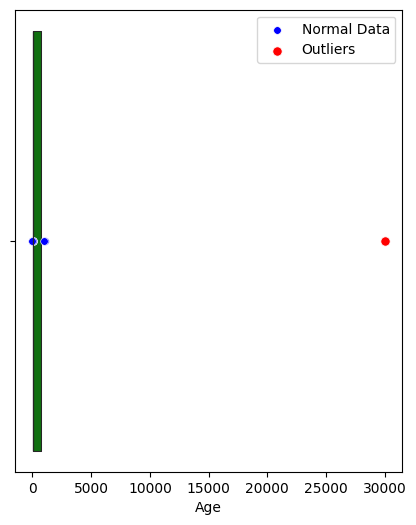

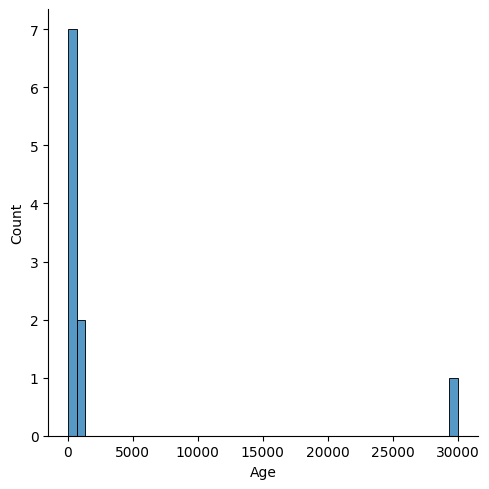

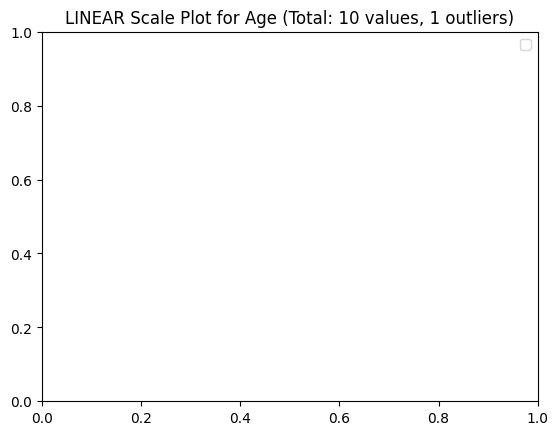

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore

# Function to calculate IQR thresholds
def calculate_iqr_thresholds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    outlier_threshold_lower = q1 - 1.5 * iqr
    outlier_threshold_upper = q3 + 1.5 * iqr
    return outlier_threshold_lower, outlier_threshold_upper

# Function to choose the outlier detection method based on the data characteristics
def choose_outlier_detection_method(df, column):
    skewness = df[column].skew()
    is_normal = abs(skewness) < 0.5
    is_high_dimensional = len(df.columns) > 10  # Check for high dimensionality
    is_clustered = len(np.unique(df[column])) < len(df[column]) * 0.1  # Heuristic for clustering
    
    if is_normal:
        print("Data is normally distributed. Using Z-score for outlier detection.")
        return 'Z-score'
    elif not is_normal and not is_high_dimensional:
        print("Data is skewed. Using IQR for outlier detection.")
        return 'IQR'
    elif is_high_dimensional:
        print("Data is high-dimensional. Using Isolation Forest for outlier detection.")
        return 'Isolation Forest'
    elif is_clustered:
        print("Data has clusters. Using Local Outlier Factor (LOF) for outlier detection.")
        return 'LOF'
    else:
        print("Using default method: IQR.")
        return 'IQR'

# Function to plot the boxen plot with outliers
def plot_boxen_with_outliers(df, column, method):
    # Choose the method dynamically for detecting outliers
    if method == 'Z-score':
        z_scores = zscore(df[column])
        outliers = df[np.abs(z_scores) > 3]
    elif method == 'IQR':
        lower_limit, upper_limit = calculate_iqr_thresholds(df[column])
        outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
    elif method == 'Isolation Forest':
        model = IsolationForest()
        outlier_preds = model.fit_predict(df[[column]])
        outliers = df[outlier_preds == -1]
    elif method == 'LOF':
        model = LocalOutlierFactor()
        outlier_preds = model.fit_predict(df[[column]])
        outliers = df[outlier_preds == -1]
    
    # Get normal data (data points that are not outliers)
    normal_data = df[~df.index.isin(outliers.index)]
    
    # Plot the results
    num_points = len(df)
    point_size = 10 if num_points > 500 else 30
    fig_width = 10 if num_points > 500 else 5

    # Create the boxen plot
    plt.figure(figsize=(fig_width, 6))
    sns.boxenplot(data=df, x=column, color="green", showfliers=False)
    sns.scatterplot(data=normal_data, x=column, y=[0] * len(normal_data), color='blue', s=point_size, label='Normal Data')
    sns.scatterplot(data=outliers, x=column, y=[0] * len(outliers), color='red', s=point_size * 1.5, label='Outliers')

    # Adjust the scale dynamically
    scale = choose_xscale(df, column)
    plt.xscale(scale) 

    # Set title and legend
    plt.title(f'{scale.upper()} Scale Plot for {column} (Total: {num_points} values, {len(outliers)} outliers)')
    plt.legend()
    
    # Show the plot
    plt.show()

# Function to choose the xscale based on data properties
def choose_xscale(df, column):
    # Count the number of data points
    num_points = df[column].count()
    data_range = df[column].max() - df[column].min()
    
    # Check if the data contains negative or zero values
    has_negatives = (df[column] < 0).any()
    has_zeros = (df[column] == 0).any()

    # Decide on the scale based on dataset size and properties
    if has_negatives:
        return 'symlog'
    elif has_zeros:
        return 'symlog' if num_points > 500 else 'linear'
    else:
        if data_range > 1000 and num_points > 100:
            return 'log'
        return 'linear' if num_points < 100 else 'log'

# Example usage (replace 'Age' with the relevant column in your dataset)
df = pd.read_csv('all_issues.csv')  # Assuming you have a DataFrame loaded

# Automatically choose the best outlier detection method for 'Age'
method = choose_outlier_detection_method(df, 'Age')

# Plot the boxen plot with the chosen method
plot_boxen_with_outliers(df, 'Age', method)


In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('all_issues.csv')

# Function to clean the column and find its majority data type
def get_majority_dtype(column):
    column_cleaned = column.dropna()
    
    # Check for numerical values
    try:
        numeric_column = pd.to_numeric(column_cleaned, errors='coerce')
        numeric_count = numeric_column.notna().sum()
    except Exception:
        numeric_count = 0
    
    # Check for date values
    try:
        date_column = pd.to_datetime(column_cleaned, errors='coerce')
        date_count = date_column.notna().sum()
    except Exception:
        date_count = 0
    
    # Count non-numeric, non-date values
    non_numeric_non_date_count = len(column_cleaned) - numeric_count - date_count
    
    # Determine majority type
    type_counts = {
        'numeric': numeric_count,
        'date': date_count,
        'non-numeric': non_numeric_non_date_count
    }
    
    majority_type = max(type_counts, key=type_counts.get)
    
    return majority_type

# Apply the function to the "Age" column
majority_dtype = get_majority_dtype(df['Age'])
print("Majority data type of 'Age':", majority_dtype)


Majority data type of 'Age': numeric


C:\Users\ACER\AppData\Local\Temp\ipykernel_8820\3936681718.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_column = pd.to_datetime(column_cleaned, errors='coerce')


In [ ]:
import pandas as pd
import numpy as np

def convert_numeric_values(value):
    try:
        # If the value can be converted to a number, return the numeric value (either int or float)
        return pd.to_numeric(value, errors='raise')
    except:
        # If it cannot be converted (e.g., it's a string like 'ace'), return the original value
        return value
    
def convert_datetime_values(value):
    try:
        return pd.to_datetime(value, errors='raise')
    except:
        return value

def map_column_in_dataset(data, column):
    # Apply the conversion function to each element in the specified column of the DataFrame
    data1= data[column].apply(convert_numeric_values)
    data2 = data[column].apply(convert_datetime_values)
    
    return data2.tolist()

# Example usage:
df = pd.read_csv('all_issues.csv')
column = 'Age'

column_data = map_column_in_dataset(df, column)
print(column_data)


['ace', 29999, 8, 32, 0.0001, 27, 30, 1080, nan, '2023-05-30']
